ThinCurr Python Example: Time-domain simulation of a cylinder {#doc_tCurr_cyl_td}
==========
In this example we demonstrate how to run a time-domain simulation for a simple ThinCurr model of a cylinder.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pyvista
pyvista.set_jupyter_backend('static') # Comment to enable interactive PyVista plots
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import circular_flux_loop, save_sensors
from OpenFUSIONToolkit.util import build_XDMF, mu0
from OpenFUSIONToolkit.io import histfile

## Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance to use for equilibrium calculations. As this is a larger model, we use `nthreads=4` to increase the number of cores used for the calculation. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
tw_torus = ThinCurr(nthreads=4)
tw_torus.setup_model(mesh_file='thincurr_ex-cyl.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          8440e61
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =         895
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =          795
  # of edges     =         2259
  # of cells     =         1464
  # of holes     =            1
  # of Vcoils    =            0
  # of closures  =            0
  # of Icoils    =            1

  Building holes

  Loading region resistivity:
     1

### Define flux loop sensors
To visualize the results we define two circular flux loops at R=0.9 m, just inside the cylinder. While every sensor in ThinCurr is a flux loop, helper classes for defining specific types of common sensors (eg. circular loop or Mirnovs) are available in \ref OpenFUSIONToolkit.ThinCurr.sensor "OpenFUSIONToolkit.ThinCurr.sensor", which also contains the \ref OpenFUSIONToolkit.ThinCurr.sensor.save_sensors "save_sensors()" function for saving this information to a ThinCurr-compatible file format.

In [4]:
sensors = [
    circular_flux_loop(0.25,0.9,'Floop_1'),
    circular_flux_loop(0.5,0.9,'Floop_2')
]
save_sensors(sensors)
Msensor, Msc, sensor_obj = tw_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           2
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


### Compute self-inductance and resistivity matrices
With the model setup, we can now compute the self-inductance and resistivity matrices. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_plate.Lmat". By default the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_tCurr_hodlr for more information).

In [5]:
Mc = tw_torus.compute_Mcoil()
tw_torus.compute_Lmat()
tw_torus.compute_Rmat()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix
 Building element<->element self inductance matrix
     Time =  0s          
 Building resistivity matrix


## Run time-domain simulation
With the model fully defined we can now use \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()" to perform a time-domain simulation. In this case we simulate 80 ms using a timestep of 0.2 ms (400 steps). We also specify using a direct solver for the time-advance (`direct=True`) and set the current in the single I-coil defined in the XML input file as a function of time (`coil_currs`), where the first column specifies time points in ascending order and the remaining columns specify coil currents at each time point.

In [6]:
dt = 2.E-4
nsteps = 400
coil_currs = np.array([
    [0.0, 0.0],
    [2.E-2, 1.E3],
    [1.0, 1.E3]
])
tw_torus.run_td(dt,nsteps,status_freq=10,coil_currs=coil_currs,sensor_obj=sensor_obj,direct=True)


 Starting simulation
 Starting factorization
 Inverting real matrix
   Time =    8.0610000000000005E-003
 Timestep           10   2.00000009E-03   1.49562431E-03           1
 Timestep           20   4.00000019E-03   2.79602758E-03           1
 Timestep           30   6.00000005E-03   3.89465201E-03           1
 Timestep           40   8.00000038E-03   4.82152030E-03           1
 Timestep           50   9.99999978E-03   5.60256746E-03           1
 Timestep           60   1.20000001E-02   6.26014080E-03           1
 Timestep           70   1.40000004E-02   6.81338552E-03           1
 Timestep           80   1.60000008E-02   7.27861980E-03           1
 Timestep           90   1.79999992E-02   7.66969658E-03           1
 Timestep          100   1.99999996E-02   7.95726292E-03           1
 Timestep          110   2.19999999E-02   6.74793730E-03           1
 Timestep          120   2.40000002E-02   5.68624772E-03           1
 Timestep          130   2.60000005E-02   4.78724064E-03          

### Plot sensor signals
We can now plot the signals from the two flux loops defined above as a function of time. During the time-domain run this information is stored in OFT's binary history file format, which can be read using the \ref OpenFUSIONToolkit.io.histfile "histfile" class. This class stores the resulting signals in a Python dict-like representation.


OFT History file: floops.hist
  Number of fields = 3
  Number of entries = 401

  Fields:
    time: Simulation time [s] (d1)
    Floop_1: No description (d1)
    Floop_2: No description (d1)



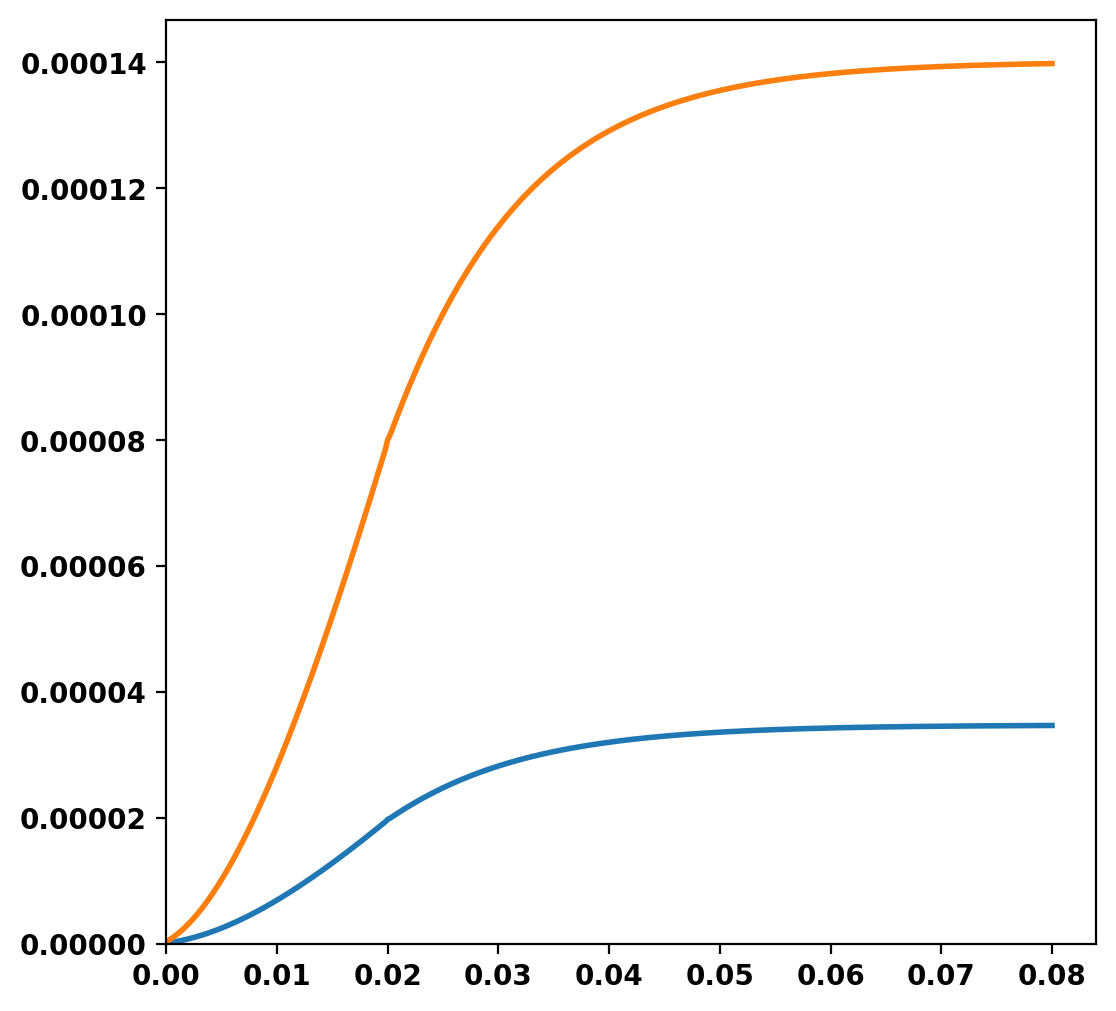

In [7]:
hist_file = histfile('floops.hist')
print(hist_file)

fig, ax = plt.subplots(1,1)
ax.plot(hist_file['time'],hist_file['Floop_1'])
ax.plot(hist_file['time'],hist_file['Floop_2'])
ax.set_ylim(bottom=0.0)
_ = ax.set_xlim(left=0.0)

### Generate plot files
After completing the simulation we can generate plot files using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.plot_td "tw_torus.plot_td()". Plot files are saved at a fixed timestep interval, specified by the `nplot` argument to \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.run_td "run_td()" with a default value of 10.

Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_torus.build_XDMF()" to generate the XDMF descriptor files for plotting with VisIt of Paraview.

In [8]:
tw_torus.plot_td(nsteps,sensor_obj=sensor_obj)
tw_torus.build_XDMF()

 Post-processing simulation
Removing old Xdmf files
Creating output files


### Plot current fields using pyvista
For demonstration purposes we now plot the the solution at the end of the driven phase using [pyvista](https://pyvista.org/). For more information on the steps in this block see \ref doc_tCurr_plate_eig

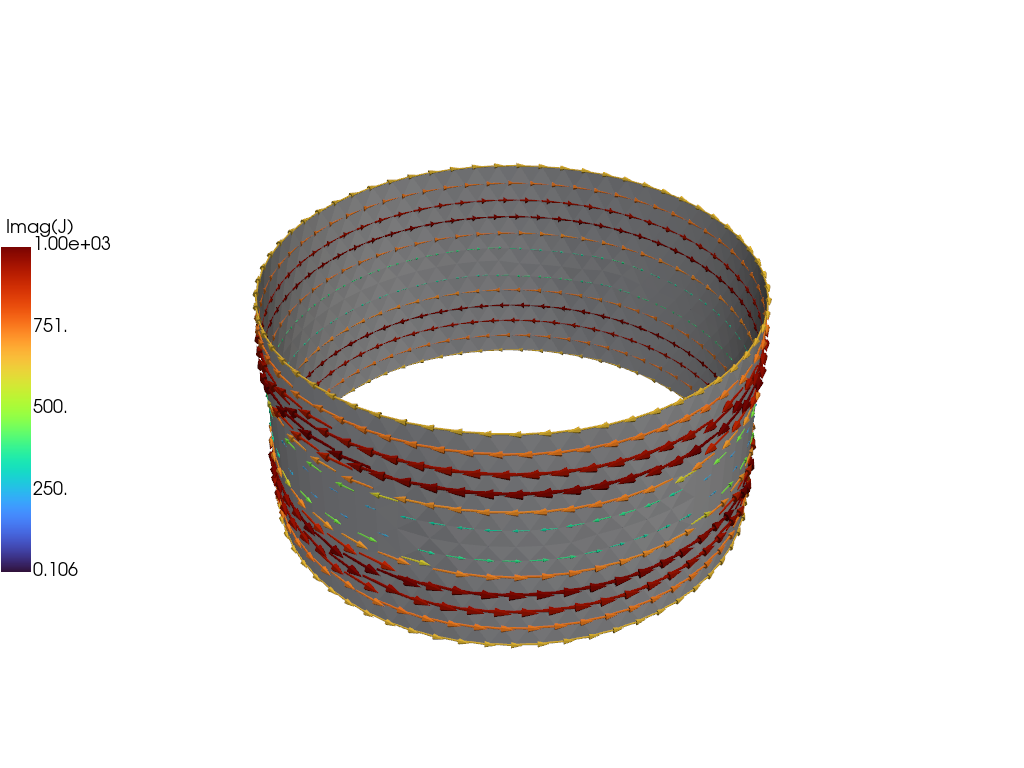

In [9]:
# Load mesh and current from plot files
with h5py.File('mesh.0001.h5','r') as h5_file:
    r = np.asarray(h5_file['R_surf'])
    lc = np.asarray(h5_file['LC_surf'])
with h5py.File('vector_dump.0001.h5','r') as h5_file:
    J = np.asarray(h5_file['J_v0011'])

# Create pyvista mesh for plotting
celltypes = np.array([pyvista.CellType.TRIANGLE for _ in range(lc.shape[0])], dtype=np.int8)
cells = np.insert(lc, [0,], 3, axis=1)
grid = pyvista.UnstructuredGrid(cells, celltypes, r)

# Plot mesh and current density using PyVista
p = pyvista.Plotter()
grid["vectors"] = J
grid.set_active_vectors("vectors")
scale = 0.2/(np.linalg.norm(J,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show()